# Forward Volatility

* fut_near_month_close, fut_far_month_close : 근월물, 원월물의 Nifty 선물 종가

* strike_price : 콜옵션 행사가

* near_month_expiry, far_month_expiry : 근월물, 원월물 만기일

* LTP_near_month, LTP_far_month : 각 근월물, 원월물의 행사가(strike) 9800 call 의 마지막 거래가격 (LTP)

In [26]:
import mibian as m
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

In [27]:
nifty_data = pd.read_csv('nifty.csv', index_col=1, parse_dates=['date', 'far_month_expiry', 'near_month_expiry'])

In [28]:
nifty_data.head()

,symbol,fut_near_month_close,fut_far_month_close,strike_price,near_month_expiry,LTP_near_month,far_month_expiry,LTP_far_month
date,,,,,,,,
2017-08-28,NIFTY,9950.80,9980.65,9800,2017-09-28,226.45,2017-10-26,293.6
2017-08-29,NIFTY,9829.40,9860.15,9800,2017-09-28,150.80,2017-10-26,219.7
2017-08-30,NIFTY,9912.45,9939.75,9800,2017-09-28,191.20,2017-10-26,259.7
2017-08-31,NIFTY,9937.20,9963.35,9800,2017-09-28,201.85,2017-10-26,266.2
2017-09-01,NIFTY,10007.30,10034.20,9800,2017-09-28,251.50,2017-10-26,312.3


## 잔존일수 계산

In [36]:
nifty_data['near_month_days_to_expiry'] = (nifty_data['near_month_expiry'] - nifty_data.index).dt.days
nifty_data['far_month_days_to_expiry'] = (nifty_data['far_month_expiry'] - nifty_data.index).dt.days
nifty_data.loc[:, ['near_month_expiry', 'near_month_days_to_expiry', 'far_month_expiry', 'far_month_days_to_expiry']].head()

,near_month_expiry,near_month_days_to_expiry,far_month_expiry,far_month_days_to_expiry
date,,,,
2017-08-28,2017-09-28,31,2017-10-26,59
2017-08-29,2017-09-28,30,2017-10-26,58
2017-08-30,2017-09-28,29,2017-10-26,57
2017-08-31,2017-09-28,28,2017-10-26,56
2017-09-01,2017-09-28,27,2017-10-26,55


In [37]:
nifty_data.head(2)

,symbol,fut_near_month_close,fut_far_month_close,strike_price,near_month_expiry,LTP_near_month,far_month_expiry,LTP_far_month,near_month_days_to_expiry,far_month_days_to_expiry
date,,,,,,,,,,
2017-08-28,NIFTY,9950.8,9980.65,9800,2017-09-28,226.45,2017-10-26,293.6,31,59
2017-08-29,NIFTY,9829.4,9860.15,9800,2017-09-28,150.80,2017-10-26,219.7,30,58


# 내재변동성 (IV) 계산

BS model 을 이용하여 내재 변동성 계산. 입력 data 는 선물 종가, 행사가, 이자율, 잔존일수, 콜옵션 가격 이다.

선물가격을 기초자산 가격으로 하므로, 이자율은 0 으로 한다.

In [58]:
nifty_data['IV_near_month'] = 0
nifty_data['IV_far_month'] = 0

for row in range(len(nifty_data)):
    nifty_data.iloc[row, nifty_data.columns.get_loc('IV_near_month')] = m.BS([
        nifty_data.iloc[row]['fut_near_month_close'], nifty_data.iloc[row]['strike_price'], 0,
        nifty_data.iloc[row]['near_month_days_to_expiry']
    ],
    callPrice=nifty_data.iloc[row]['LTP_near_month']
    ).impliedVolatility
    
    nifty_data.iloc[row, nifty_data.columns.get_loc('IV_far_month')] = m.BS([
        nifty_data.iloc[row]['fut_far_month_close'], nifty_data.iloc[row]['strike_price'], 0,
        nifty_data.iloc[row]['far_month_days_to_expiry']
    ],
    callPrice=nifty_data.iloc[row]['LTP_far_month']
    ).impliedVolatility

nifty_data.loc[:, ['IV_near_month', 'IV_far_month']].head(2)

,IV_near_month,IV_far_month
date,,
2017-08-28,12.033463,11.962891
2017-08-29,12.077332,12.031555


## forward volatility 계산

In [60]:
# 근월물과 원월물에 대한 각각의 variance 계산
nifty_data['variance_near_month'] = (nifty_data.IV_near_month**2/365) * nifty_data.near_month_days_to_expiry
nifty_data['variance_far_month'] = (nifty_data.IV_far_month**2/365) * nifty_data.far_month_days_to_expiry

# 두 variance 의 차이를 계산
nifty_data['variance_diff'] = nifty_data.variance_far_month - nifty_data.variance_near_month
nifty_data['forward_variance_days'] = nifty_data.far_month_days_to_expiry - nifty_data.near_month_days_to_expiry

# forward variance 를 forward volatility 로 convert
nifty_data['forward_volatility'] = (nifty_data.variance_diff * 365 / nifty_data.forward_variance_days)**0.5

In [62]:
nifty_data.head(2)

,symbol,fut_near_month_close,fut_far_month_close,strike_price,near_month_expiry,LTP_near_month,far_month_expiry,LTP_far_month,near_month_days_to_expiry,far_month_days_to_expiry,IV_near_month,IV_far_month,variance_near_month,variance_far_month,variance_diff,forward_variance_days,forward_volatility
date,,,,,,,,,,,,,,,,,
2017-08-28,NIFTY,9950.8,9980.65,9800,2017-09-28,226.45,2017-10-26,293.6,31,59,12.033463,11.962891,12.298441,23.132971,10.83453,28,11.884269
2017-08-29,NIFTY,9829.4,9860.15,9800,2017-09-28,150.80,2017-10-26,219.7,30,58,12.077332,12.031555,11.988652,23.002692,11.01404,28,11.982315


# 거래 signal 생성

forward volatility 가 근월물의 volatility 보다 크면 원월물이 근월물 옵션보다 비싸다는 것을 나타내므로 원월물을 팔고, 근월물을 산다.

-1 을 signal column 에 저장함.

In [64]:
nifty_data['signal'] = np.where(nifty_data.forward_volatility > nifty_data.IV_near_month, -1, 1)
nifty_data.loc[:, ['forward_volatility', 'IV_near_month', 'signal']].head()

,forward_volatility,IV_near_month,signal
date,,,
2017-08-28,11.884269,12.033463,1
2017-08-29,11.982315,12.077332,1
2017-08-30,11.836732,11.474609,-1
2017-08-31,11.218733,11.104584,-1
2017-09-01,10.958989,11.215210,1


# Strategy returns

Strategy return 은 원월물과 근월물의 수익 차이를 계산하여 전일자의 trading signal (+1, -1) 을 곱하여 구한다.

In [70]:
nifty_data['far_month_ret'] = np.log(nifty_data.LTP_far_month/nifty_data.LTP_far_month.shift(1))
nifty_data['near_month_ret'] = np.log(nifty_data.LTP_near_month/nifty_data.LTP_near_month.shift(1))

nifty_data['strategy_return'] = (nifty_data.far_month_ret - nifty_data.near_month_ret) * nifty_data.signal.shift(1)

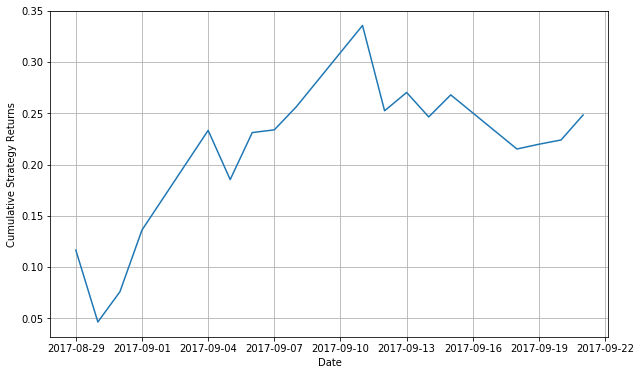

In [74]:
plt.figure(figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Cumulative Strategy Returns')
plt.plot(nifty_data.strategy_return.cumsum())
plt.grid()

이 전략은 1 개월간 약 25% 의 return 을 보임